# Classifier execution: ordinal dataset

### Process Flow :

1. load **ordinal dataset** and create control data
2. setup training and testing 
3. generate assessments for the following classifiers:
    * GaussianNB
    * MultinomialNB
    * KNN

### Input data

**ordinal dataset**: from RTA_DS_Classifiers

### Output data

* saved data assessment plot (.png) snapshots: for each classifier
    * confusion matricies
    * cross-validation
    * learning curves
    * hypertuning (KNN only)

## Import external libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold

import itertools
import time

C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 'Import' RTAutilities

In [2]:
def accuracy_report(_clf):
    print ("Accuracy: %0.2f%%" % (100 * _clf.score(X_test, y_test)))

    #Print the accuracy on the test and training dataset
    training_accuracy = _clf.score(X_train, y_train)
    test_accuracy = _clf.score(X_test, y_test)

    print ("Accuracy on training data: %0.2f" % (training_accuracy))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Accident Severity Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    IL: amended from ....
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    """
    IL: Amended conditional statemet:
        * address floating point 'np.set_printoptions(precision=2)' not working
        * tailor for output narration
    """
    if normalize:
        cm = cm.astype(int)*1000 / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype(float)/1000
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="grey" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    """
    IL: Amended to include save picture
    """
    plt.savefig('Data/Pics/' + title + '.png')
    
def plot_confusions(yt, yp, clf):
    """
    IL: created May 2017
    """
    #Accident severity categories
    class_names = ['Fatal','Serious','Slight']
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(yt, yp)
    ###np.set_printoptions(precision=2)
    
    print (clf + ' Confusion Matrix:')
    print 'Accuracy score: %s' % accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    
    # Plot and save non-normalized confusion matrix
    title = clf + '(UnNorm)'
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title=title)
    plt.show()   

    # Plot normalized confusion matrix
    title = clf + '(Norm)'
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title=title)
    plt.show()

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from numpy import ravel

def RTA_Classifier(df, classifier, predictor, feature):    
    X = pd.DataFrame(df[feature])
    y = pd.DataFrame(df[predictor])
    lr = LinearRegression(n_jobs=1,fit_intercept=True)
    logreg = linear_model.LogisticRegression(C=1e5)
    plt.ylabel(predictor)
    plt.xlabel(feature)
        
    if classifier == 'linear':
        lr = LinearRegression(n_jobs=1,fit_intercept=True)
        lr.fit(X,y)
        clf_p = lr.predict(X)
        plt.scatter(df[feature], df[predictor])
        plt.plot(df[feature], clf_p, color='red')
    elif classifier == 'logistic':
        plt.figsize=(9, 6)
        #plt.xticks(range(0, 20010, 5000))
        plt.yticks([0, 0.5, 1])
        plt.ylim(-0.1, 1.1)
        #plt.xlim(0, 20000)
        df.sort_values(feature, inplace=True) # replaced by ravel function??
        
        # Linear regression
        lr.fit(X,y)
        clf_plr = lr.predict(X)
        plt.scatter(df[feature], df[predictor], color='g', zorder=20)
        plt.plot(df[feature], clf_plr, color='blue')
        
        #Logistic regression
        logreg.fit(X,y)
        clf_plog = logreg.predict(X)
        #plt.scatter(df_X[feature].ravel(), df_X[predictor])
        plt.plot(df[feature].ravel(), clf_plog, color='red', zorder = 20)
        plt.legend(('Linear Regression Model', 'Logistic Regression Model'),
                   loc="best", fontsize='small')       

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


#digits = load_digits()
#X, y = digits.data, digits.target

## Set up data for features and outcome determination

In [5]:
# read dataset and perform any 'final' data clean
dataset_name = 'ordinal'
df_features = pd.read_pickle('Data/RTA_ordinal_dataset.pickle')

df_features[df_features < 1] = 0 # Some classifiers need to have positive integers
df_features = df_features.dropna() # removal of any residual NaN records
df_features = df_features.astype(np.int64, errors='ignore') #convert records to int

In [6]:
#separate out the item required for prediction. Control leaves outcome as a feature

X = df_features.drop('accident_severity',1)
#X = df_features
y = df_features.accident_severity

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=5)

## Assess classifiers - Confusion matricies

Ordinal_GaussianNB Confusion Matrix:
Accuracy score: 0.849584568366


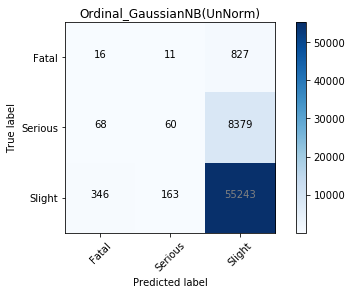

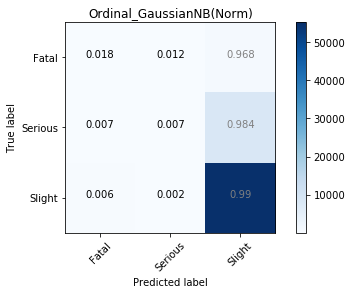

In [7]:
clf = dataset_name + '_GaussianNB'
# testing accuracy of Gaussian Naive Bayes
clf_g = GaussianNB().fit(X_train, y_train)
y_pred = clf_g.predict(X_test)

#accuracy_report(clf_g)
plot_confusions(y_test, y_pred, clf)

Ordinal_MultinomialNB Confusion Matrix:
Accuracy score: 0.855620229447


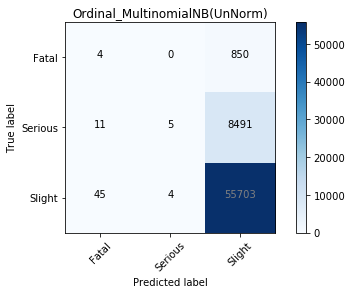

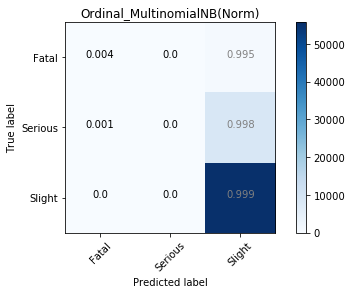

In [8]:
clf = dataset_name + '_MultinomialNB'
# testing accuracy of Gaussian Naive Bayes
clf_g = MultinomialNB().fit(X_train, y_train)
y_pred = clf_g.predict(X_test)

#accuracy_report(clf_g)
plot_confusions(y_test, y_pred, clf)

Ordinal_KNN Confusion Matrix:
Accuracy score: 0.761568350406


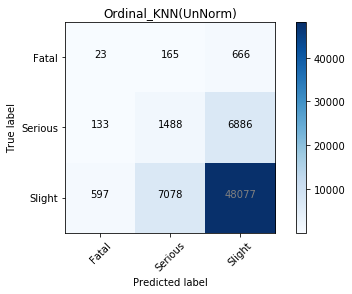

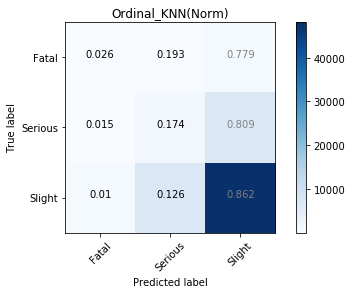

In [9]:
clf = dataset_name + '_KNN'
# testing accuracy of Gaussian Naive Bayes
knn = KNeighborsClassifier(n_neighbors=1)
clf_k = knn.fit(X_train, y_train)
y_pred = clf_k.predict(X_test)

#accuracy_report(clf_g)
plot_confusions(y_test, y_pred, clf)

## Assess classifiers - Cross-validation

### GaussianNB

In [10]:
clf = dataset_name + '_GaussianNB_cv'
clf_g = GaussianNB()
scores = cross_val_score(clf_g, X, y, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.85379937  0.85293937  0.85085079  0.85127165  0.84377688  0.84973584
  0.84875292  0.84906008  0.84985871  0.84781273]
0.849785833861


In [11]:
start_time0 = time.time()
k_range = range(2,51)
k_scores = []

#Iterate over folds
for k in k_range:
    clf_g = GaussianNB()
    scores = cross_val_score(clf_g, X, y, cv=k, scoring='accuracy')
    k_scores.append(scores.mean())
    
k_scores
print "cv folds - GaussianNB: %s seconds " % (time.time() - start_time0)

cv folds - GaussianNB: 201.601000071 seconds 


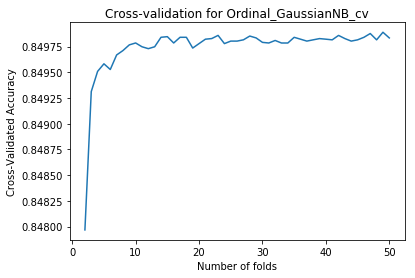

In [12]:
plt.plot(k_range,k_scores)
plt.title('Cross-validation for ' + clf)
plt.xlabel('Number of folds')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig('Data/Pics/'+ clf + '.png')
plt.show()

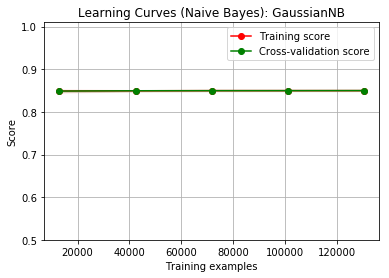

Learning curves - GaussianNB: 74.5020000935 seconds 


In [13]:
start_time0 = time.time()

title = "Learning Curves (Naive Bayes): GaussianNB"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig('Data/Pics/' + clf + '_lc.png')
plt.show()

print "Learning curves - GaussianNB: %s seconds " % (time.time() - start_time0)

### MulitnomialNB

In [14]:
clf = dataset_name + '_MultinomialNB_cv'

clf_mn = MultinomialNB()
scores = cross_val_score(clf_mn, X, y, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.85533509  0.85521224  0.85453652  0.85538764  0.84893722  0.85366753
  0.8534218   0.85391326  0.85489618  0.85389531]
0.853920277103


In [15]:
start_time0 = time.time()
k_range = range(2,51)
k_scores = []

#Iterate over folds
for k in k_range:
    clf_m = MultinomialNB()
    scores = cross_val_score(clf_mn, X, y, cv=k, scoring='accuracy')
    k_scores.append(scores.mean())
    
k_scores
print "cv folds - MultinomialNB: %s seconds " % (time.time() - start_time0)

cv folds - MultinomialNB: 156.013000011 seconds 


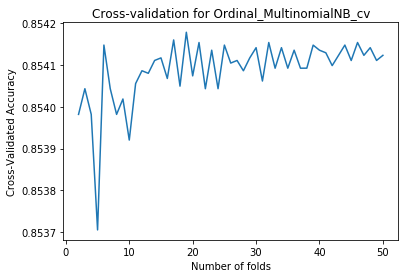

In [16]:
plt.plot(k_range,k_scores)
plt.title('Cross-validation for ' + clf)
plt.xlabel('Number of folds')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig('Data/Pics/' + clf + '.png')
plt.show()

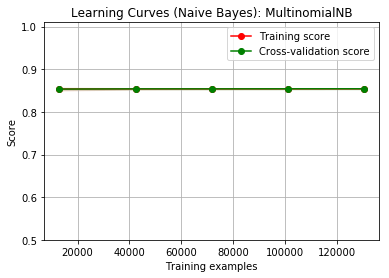

Shufflesplit - MultinomialNB: 51.7769999504 seconds 


In [17]:
start_time0 = time.time()

title = "Learning Curves (Naive Bayes): MultinomialNB"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig('Data/Pics/'+ clf + '_lc.png')
plt.show()

print "Shufflesplit - MultinomialNB: %s seconds " % (time.time() - start_time0)

### KNN

In [18]:
clf = dataset_name + '_KNN_cv'

clf_knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(clf_knn, X, y, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.75459181  0.76116469  0.76577185  0.7567883   0.7624401   0.76096572
  0.7626244   0.75623541  0.75052218  0.75024576]
0.758135022504


In [19]:
start_time0 = time.time()
k_range = range(2,11)
k_scores = []

#Iterate over folds
for k in k_range:
    clf_knn = KNeighborsClassifier(n_neighbors=1)
    scores = cross_val_score(clf_knn, X, y, cv=k, scoring='accuracy')
    k_scores.append(scores.mean())
    
k_scores
print "cv folds - MultinomialNB: %s seconds " % (time.time() - start_time0)

cv folds - MultinomialNB: 2061.77600002 seconds 


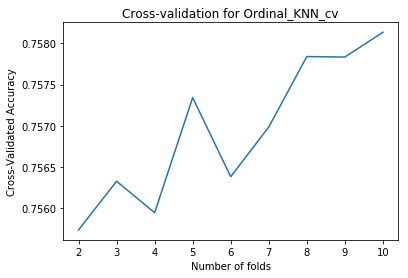

In [20]:
plt.plot(k_range,k_scores)
plt.title('Cross-validation for ' + clf)
plt.xlabel('Number of folds')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig('Data/Pics/' + clf + '.png')
plt.show()

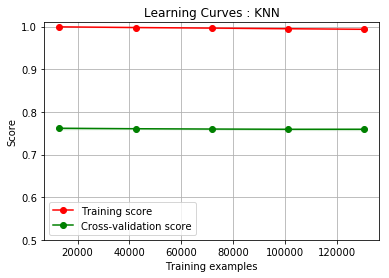

Shufflesplit - KNN: 1057.68000007 seconds 


In [22]:
start_time0 = time.time()

title = "Learning Curves : KNN"
# KNN is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier(n_neighbors=1)
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig('Data/Pics/' + clf + '_lc.png')
plt.show()

print "Shufflesplit - KNN: %s seconds " % (time.time() - start_time0)

In [23]:
start_time0 = time.time()
k_range = range(1, 10)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
k_scores
print "Hypertuning - KNN: %s seconds " % (time.time() - start_time0)

Hypertuning - KNN: 5659.52600002 seconds 


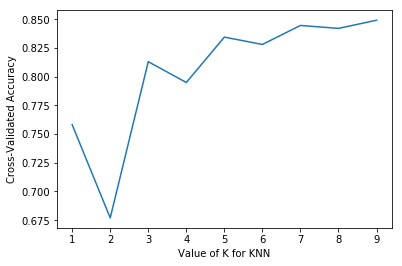

In [24]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.savefig('Data/Pics/'+ clf + '_hyper.png')
plt.show()

#### Example diagram for earlier dataset classifier testing

![KNN hyper tuning](Data/Pics/hyper_ordinal2.png)